### Cross-input methods comparison
- 60
  - Quantitatively
    - Hard to grasp the difference between each approach. Attention+mask and Base has a bit more consistent results, maybe due to binary mask which is easier to generate shadow with. Attention approach seems to meet the resistance at 4 global RMSE level, while two others did not. The same, but smaller, effect is at local level too.
    - Generator losses also seems to have little difference, except Attention+mask G_A2B values which error is significantly less that two others.
    - Discriminator losses have different levels for each approach in the beginning, but seems to converge at the end.
    - Attn + mask seems to be better solution compared to others two, they complement each other giving more consistent filling and better masks.
  
  - Qualtitatively
    - If we compare the results of base and attention+mask we can see that attention gives better results and in some way corrects the results of binary mask. On some test images it better defines shadow regions while base case can not find the shadow and highlights all image.
    - Attention-only needs to be trained for more.

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')
path_basic = 'drive/My Drive/gan_experiments'
os.chdir(path_basic)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid');

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import pandas as pd
import numpy as np
import scipy.stats as st
import glob

from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

In [0]:
def sit_to_dict(summary_iterators, tags, default_tag='G/GAN_A2B'):
  tag_values = defaultdict(list)

  for i in range(len(summary_iterators)):
    if i == len(summary_iterators) - 1:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag]
        tag_values[tag].extend(values_now)

      print(f"S-{i}: first:last step - {steps_now[0]}:{steps_now[-1]} - {len(steps_now)}")
    else:
      steps_now = [e.step for e in summary_iterators[i].Scalars(default_tag)]
      steps_next = [e.step for e in summary_iterators[i+1].Scalars(default_tag)]
      start = min(steps_now)
      stop = min(steps_next)
      if start - stop == 0:
        continue

      for tag in tags:
        try:
          event_tag = summary_iterators[i].Scalars(tag)
        except:
          continue
        values_now = [(e.step,e.value) for e in event_tag if e.step <= stop]
        tag_values[tag].extend(values_now)
      print(f"S-{i}: first:last step - {start}:{stop} - {len(steps_now)}")

    

  return tag_values

In [0]:
def get_sit(path):
  summary_iterators = [EventAccumulator(path_).Reload() 
                    for path_ in sorted(glob.glob(os.path.join(path, "*.*")))
                    ]
  summary_iterators = [s for s in summary_iterators if len(s.Tags()['scalars']) > 0]
  return summary_iterators


def get_csv(dict_object, tag):

  values = dict_object[tag]
  steps = [s[0] for s in values]
  values = [v[1] for v in values]

  df = pd.DataFrame(columns=['index', 'values'])
  df['index'] = steps
  df['values'] = values
  df = df.set_index('index')
  return df

In [0]:
def get_results_dict(path, stop_it):
  summary_iterator = get_sit(path)
  tags = summary_iterator[0].Tags()['scalars']
  tag_values = sit_to_dict(summary_iterator, tags)

  results = {}
  for tag in tags:
    df_values = get_csv(tag_values, tag)
    df_values = df_values[df_values.index < stop_it].copy()
    results[tag] = df_values.copy()

  return results

### Cross base method


In [0]:
# !kill 334

In [0]:
# %load_ext tensorboard
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_cam_v0.0.1/1/'
# %tensorboard --logdir='mask_shadow_gan/output/summary/summary_dilated_v0.0.1/1/'

In [0]:
os.listdir('mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1')

['summary_cam_notrans_v0.0.1',
 'summary_cam_trans_nomask_v0.0.1',
 'summary_ins_reb_v0.0.1',
 'summary_ins_cat_v0.0.1',
 'summary_cam_base_v0.0.1',
 'summary_cam_v0.0.1']

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1/1/'

In [0]:
STOP_IT = 1e6  # take all
print("V.0.1.0")
results_010 = get_results_dict(PATH_010, STOP_IT)

V.0.1.0
S-0: first:last step - 10:1240 - 123
S-1: first:last step - 1240:8620 - 1073
S-2: first:last step - 8620:46960 - 3835


In [0]:
tag_score = 'Score/val_rmse_whole'
df_spec_score_global_010 = results_010[tag_score]

tag_score = 'Score/val_rmse_region'
df_spec_score_local_010 = results_010[tag_score]

tag_iou = 'Score/val_iou'
df_spec_iou_010 = results_010[tag_iou]

In [0]:
def scale(df):
  return df / df.mean()

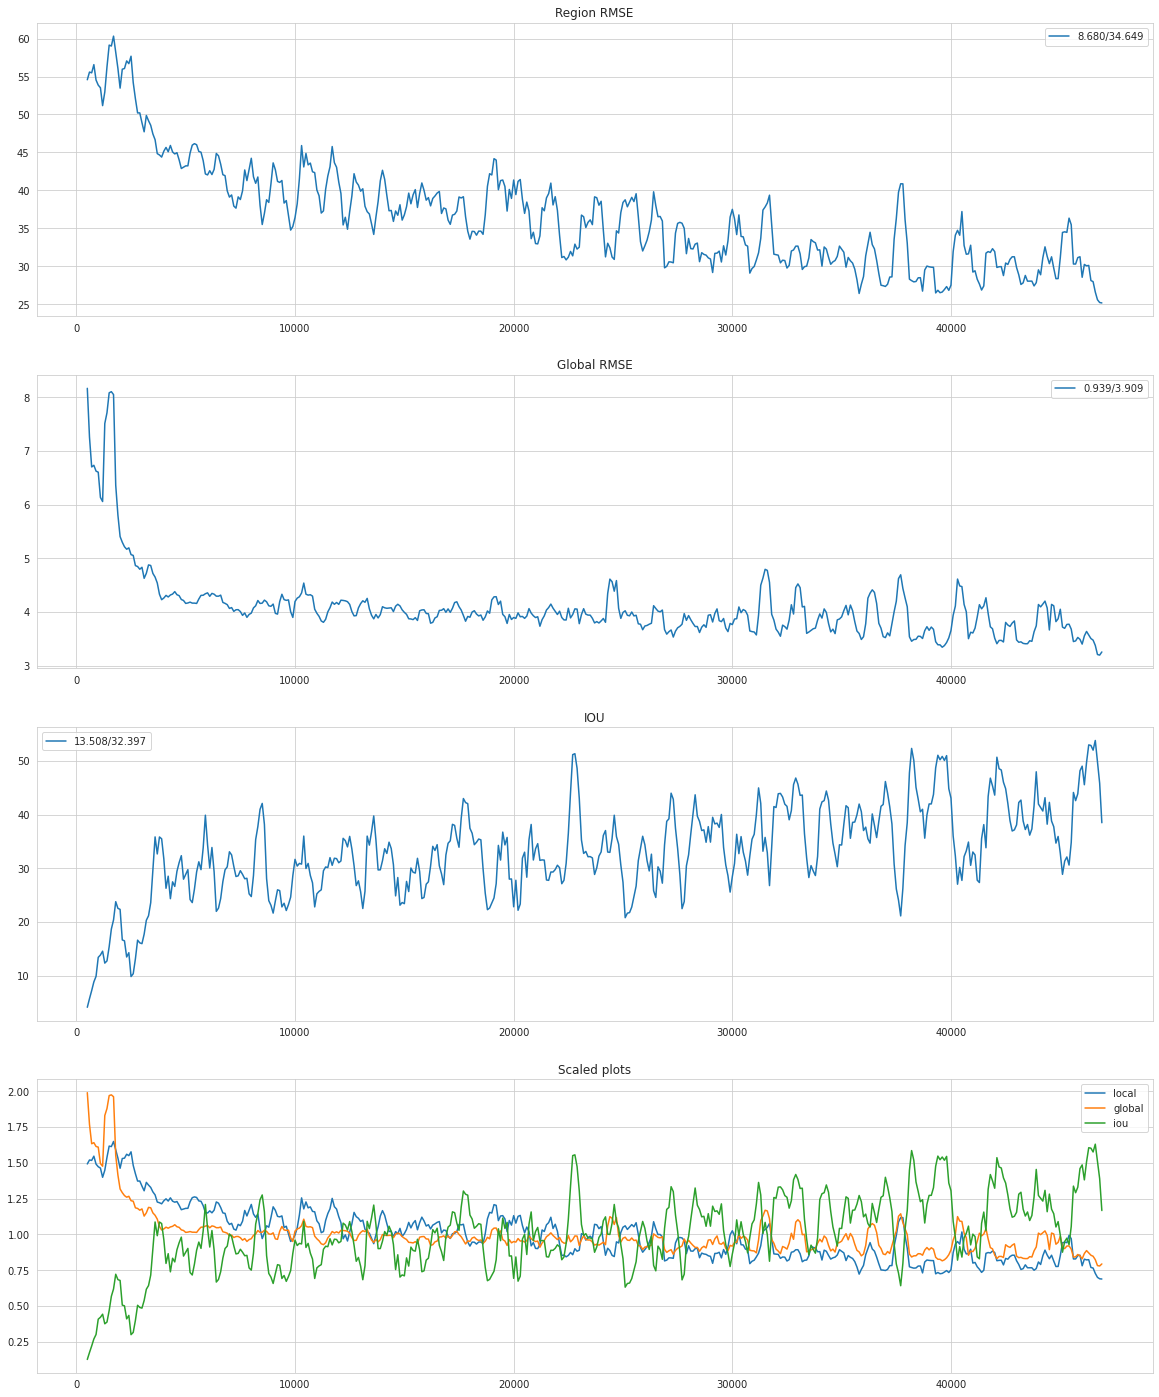

In [0]:
rm=5
plt.subplots(figsize=(20,10))
plt.subplot(4,1,1)
plt.title("Region RMSE")
plt.plot(df_spec_score_local_010.rolling(rm).mean(), 
          label=f'{df_spec_score_local_010.std()[0]:.3f}/{df_spec_score_local_010.median()[0]:.3f}');
plt.legend();


plt.subplot(4,1,2)
plt.title("Global RMSE")
plt.plot(df_spec_score_global_010.rolling(rm).mean(), 
          label=f'{df_spec_score_global_010.std()[0]:.3f}/{df_spec_score_global_010.median()[0]:.3f}');
plt.legend();

plt.subplot(4,1,3)
plt.title("IOU")
plt.plot(df_spec_iou_010.rolling(rm).mean(), 
          label=f'{df_spec_iou_010.std()[0]:.3f}/{df_spec_iou_010.median()[0]:.3f}');
plt.legend();

plt.subplot(4, 1, 4)
data = (('local', scale(df_spec_score_local_010)),
        ('global',  scale(df_spec_score_global_010)),
        ('iou',  scale(df_spec_iou_010)))

for i,(label, score) in enumerate(data):
  plt.title("Scaled plots")
  plt.plot(score.rolling(rm).mean(), label=f"{label}")
  plt.legend();

plt.subplots_adjust(top=2);

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]

tag_db_real = 'D/D_B_real'
df_spec_db_real_010 = results_010[tag_db_real]


tag_db_fake = 'D/D_B_fake'
df_spec_db_fake_010 = results_010[tag_db_fake]

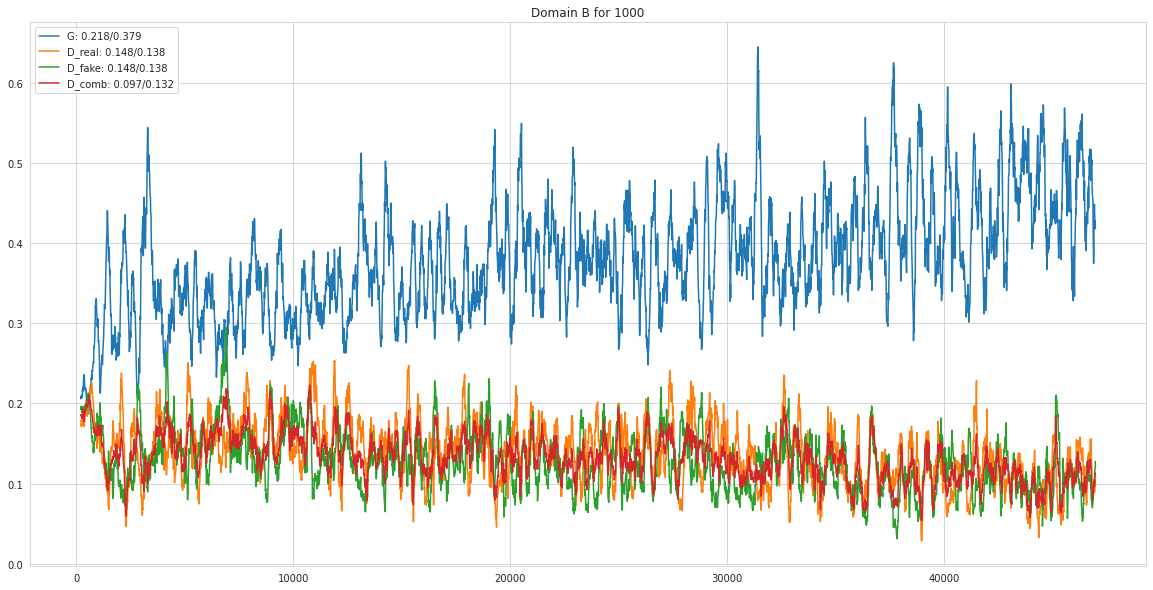

In [0]:
rm = 20
plt.subplots(figsize=(20,10))
plt.title("Domain B for 1000")
plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');

plt.plot(df_spec_db_real_010.rolling(rm).mean(), 
         label=f'D_real: {df_spec_db_real_010.std()[0]:.3f}/{df_spec_db_real_010.mean()[0]:.3f}');
plt.plot(df_spec_db_fake_010.rolling(rm).mean(), 
         label=f'D_fake: {df_spec_db_real_010.std()[0]:.3f}/{df_spec_db_real_010.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]

tag_da_real = 'D/D_A_real'
df_spec_da_real_010 = results_010[tag_da_real]

tag_da_fake = 'D/D_A_fake'
df_spec_da_fake_010 = results_010[tag_da_fake]

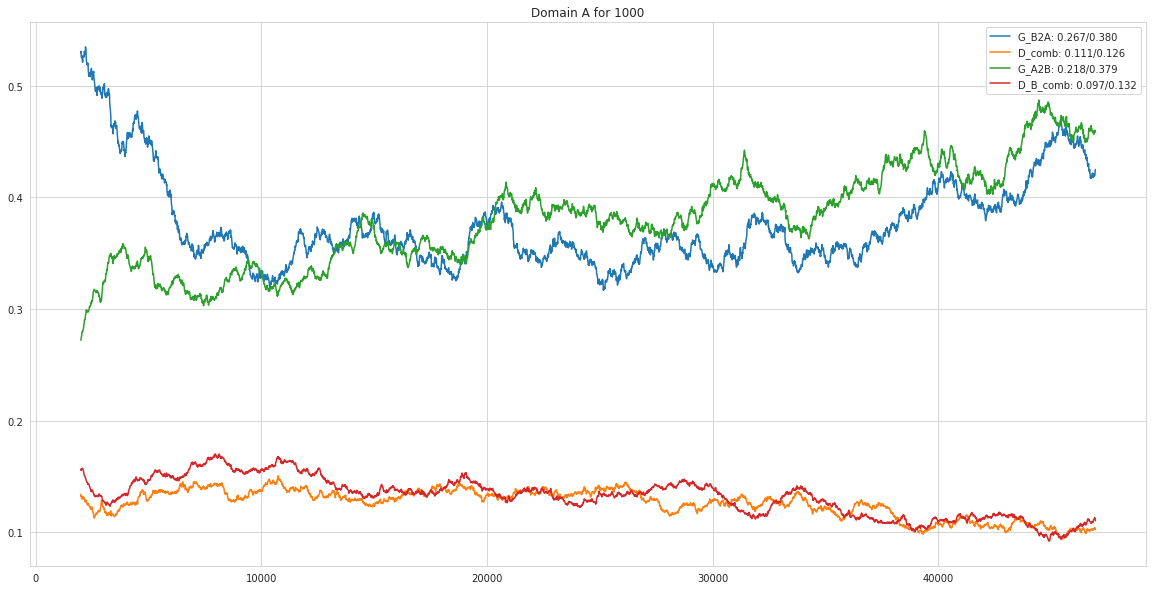

In [0]:
rm = 200
plt.subplots(figsize=(20,10))
plt.title("Domain A for 1000")
plt.plot(df_spec_gba_010.rolling(rm).mean(), 
         label=f'G_B2A: {df_spec_gba_010.std()[0]:.3f}/{df_spec_gba_010.mean()[0]:.3f}');

# combined
df_spec_da_fake_comb_010 = (df_spec_da_real_010 + df_spec_da_fake_010) / 2
plt.plot(df_spec_da_fake_comb_010.rolling(rm).mean(), 
         label=f'D_comb: {df_spec_da_fake_comb_010.std()[0]:.3f}/{df_spec_da_fake_comb_010.mean()[0]:.3f}');


plt.plot(df_spec_gab_010.rolling(rm).mean(), 
         label=f'G_A2B: {df_spec_gab_010.std()[0]:.3f}/{df_spec_gab_010.mean()[0]:.3f}');
# combined
df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
plt.plot(df_spec_db_fake_comb_010.rolling(rm).mean(), 
         label=f'D_B_comb: {df_spec_db_fake_comb_010.std()[0]:.3f}/{df_spec_db_fake_comb_010.mean()[0]:.3f}');

plt.legend();

### Comparison of crosses inputs

In [0]:
PATH_010 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_base_v0.0.1/1/'
PATH_011 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_trans_nomask_v0.0.1/1/'
PATH_012 = 'mask_shadow_gan/output/summary/cam_cross/summary_cam_v0.0.1/1/'
PATH_013 = 'mask_shadow_gan/output/summary/cam_cross/summary_ins_reb_v0.0.1/1/'

In [25]:
STOP_IT = 1e6  # take all
print("Cross base")
results_010 = get_results_dict(PATH_010, STOP_IT)

print("\nCross attn only")
results_011 = get_results_dict(PATH_011, STOP_IT)

print("\nAttn + mask")
results_012 = get_results_dict(PATH_012, STOP_IT)

print("\nInside rebalance")
results_013 = get_results_dict(PATH_013, STOP_IT)

Cross base
S-0: first:last step - 10:1240 - 123
S-1: first:last step - 1240:8620 - 1073
S-2: first:last step - 8620:46750 - 3835
S-3: first:last step - 46750:66430 - 2026
S-4: first:last step - 66430:73810 - 1217
S-5: first:last step - 73810:86100 - 1230

Cross attn only
S-1: first:last step - 10:7390 - 1043
S-2: first:last step - 7390:14770 - 1173
S-3: first:last step - 14770:34450 - 1990
S-4: first:last step - 34450:41830 - 1249
S-5: first:last step - 41830:49210 - 1218
S-6: first:last step - 49210:61360 - 1215
S-7: first:last step - 61360:71200 - 1235
S-8: first:last step - 71200:84730 - 1540
S-9: first:last step - 84730:85960 - 604
S-10: first:last step - 85960:98260 - 1231

Attn + mask
S-0: first:last step - 10:910 - 90
S-1: first:last step - 910:2140 - 202
S-2: first:last step - 2140:9520 - 850
S-3: first:last step - 9520:23050 - 1959
S-4: first:last step - 23050:61180 - 4007
S-5: first:last step - 61180:99310 - 3889
S-6: first:last step - 99310:118990 - 1969

Inside rebalance
S-

In [0]:
assert all([s in results_011.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])
assert all([s in results_010.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])
assert all([s in results_012.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])
assert all([s in results_013.keys() for s in ['Score/val_rmse_region', 'Score/val_iou', 'Score/val_rmse_whole'] ])

In [0]:
tag_score = 'Score/val_rmse_region'
df_spec_score_region_010 = results_010[tag_score]
df_spec_score_region_011 = results_011[tag_score]
df_spec_score_region_012 = results_012[tag_score]
df_spec_score_region_013 = results_013[tag_score]


tag_score = 'Score/val_rmse_whole'
df_spec_score_whole_010 = results_010[tag_score]
df_spec_score_whole_011 = results_011[tag_score]
df_spec_score_whole_012 = results_012[tag_score]
df_spec_score_whole_013 = results_013[tag_score]


tag_iou = 'Score/val_iou'
df_spec_iou_010 = results_010[tag_iou]
df_spec_iou_011 = results_011[tag_iou]
df_spec_iou_012 = results_012[tag_iou]
df_spec_iou_013 = results_013[tag_iou]

In [0]:
df_spec_score_region_012 = df_spec_score_region_012.iloc[(df_spec_score_region_012.index % 100 == 0)]
df_spec_score_whole_012 = df_spec_score_whole_012.iloc[(df_spec_score_whole_012.index % 100 == 0)]
df_spec_iou_012 = df_spec_iou_012.iloc[(df_spec_iou_012.index % 100 == 0)]

In [30]:
df_spec_score_region_010.shape[0], df_spec_score_region_011.shape[0], df_spec_score_region_012.shape[0], df_spec_score_region_013.shape[0]

(860, 983, 1189, 611)

In [0]:
# min_len = int(1e6)
min_len = min(len(df_spec_score_region_010), len(df_spec_score_region_011), 
              len(df_spec_score_region_012), len(df_spec_score_region_013))

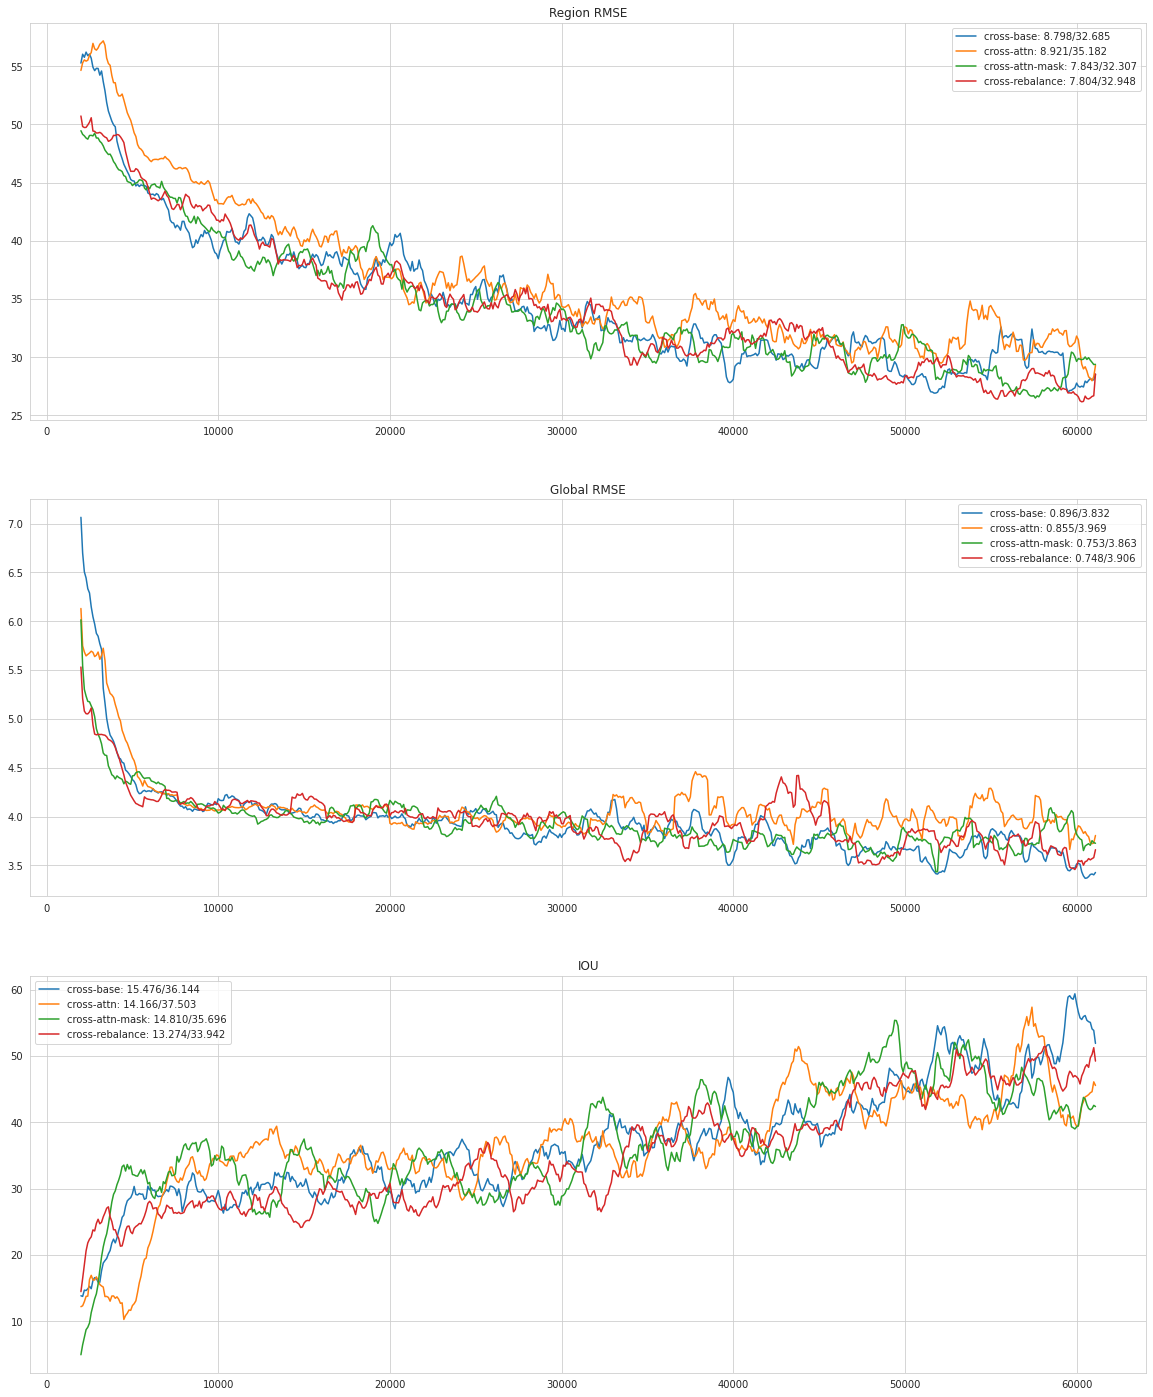

In [33]:
rm=20
plt.subplots(figsize=(20,10))
plt.subplot(3,1,1)
plt.title("Region RMSE")
data = [('cross-base', df_spec_score_region_010.iloc[:min_len]), 
        ('cross-attn', df_spec_score_region_011.iloc[:min_len]),
        ('cross-attn-mask', df_spec_score_region_012.iloc[:min_len]),
        ('cross-rebalance', df_spec_score_region_013.iloc[:min_len])]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();


plt.subplot(3,1,2)
plt.title("Global RMSE")
data = [('cross-base', df_spec_score_whole_010.iloc[:min_len]), 
        ('cross-attn', df_spec_score_whole_011.iloc[:min_len]),
        ('cross-attn-mask', df_spec_score_whole_012.iloc[:min_len]),
        ('cross-rebalance', df_spec_score_whole_013.iloc[:min_len])]
for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();

plt.subplot(3,1,3)
plt.title("IOU")
data = [('cross-base', df_spec_iou_010.iloc[:min_len]), 
        ('cross-attn', df_spec_iou_011.iloc[:min_len]),
        ('cross-attn-mask', df_spec_iou_012.iloc[:min_len]),
        ('cross-rebalance', df_spec_iou_013.iloc[:min_len])]

for label, d in data:
  plt.plot(d.rolling(rm).mean(), 
          label=f'{label}: {d.std()[0]:.3f}/{d.median()[0]:.3f}');
plt.legend();


plt.subplots_adjust(top=2);

- Global rmse has rather slow convergence combined with more volatile loss compared to dilated counterpart
  - It may say about bad background reconstruction, this should be further examined with identity loss and visual comparison

- Local RMSE seems to have a strong negative trend for all coefficients.
- Same situation goes for IOU. So we generate better masks with time.

In average, 100 coefficient shows better behaviour on all graphs.

### Look at correlation of region rmse with iou

In [0]:
def scale(df):
  # return (df - df.mean()) / df.std()
  return df / df.mean()

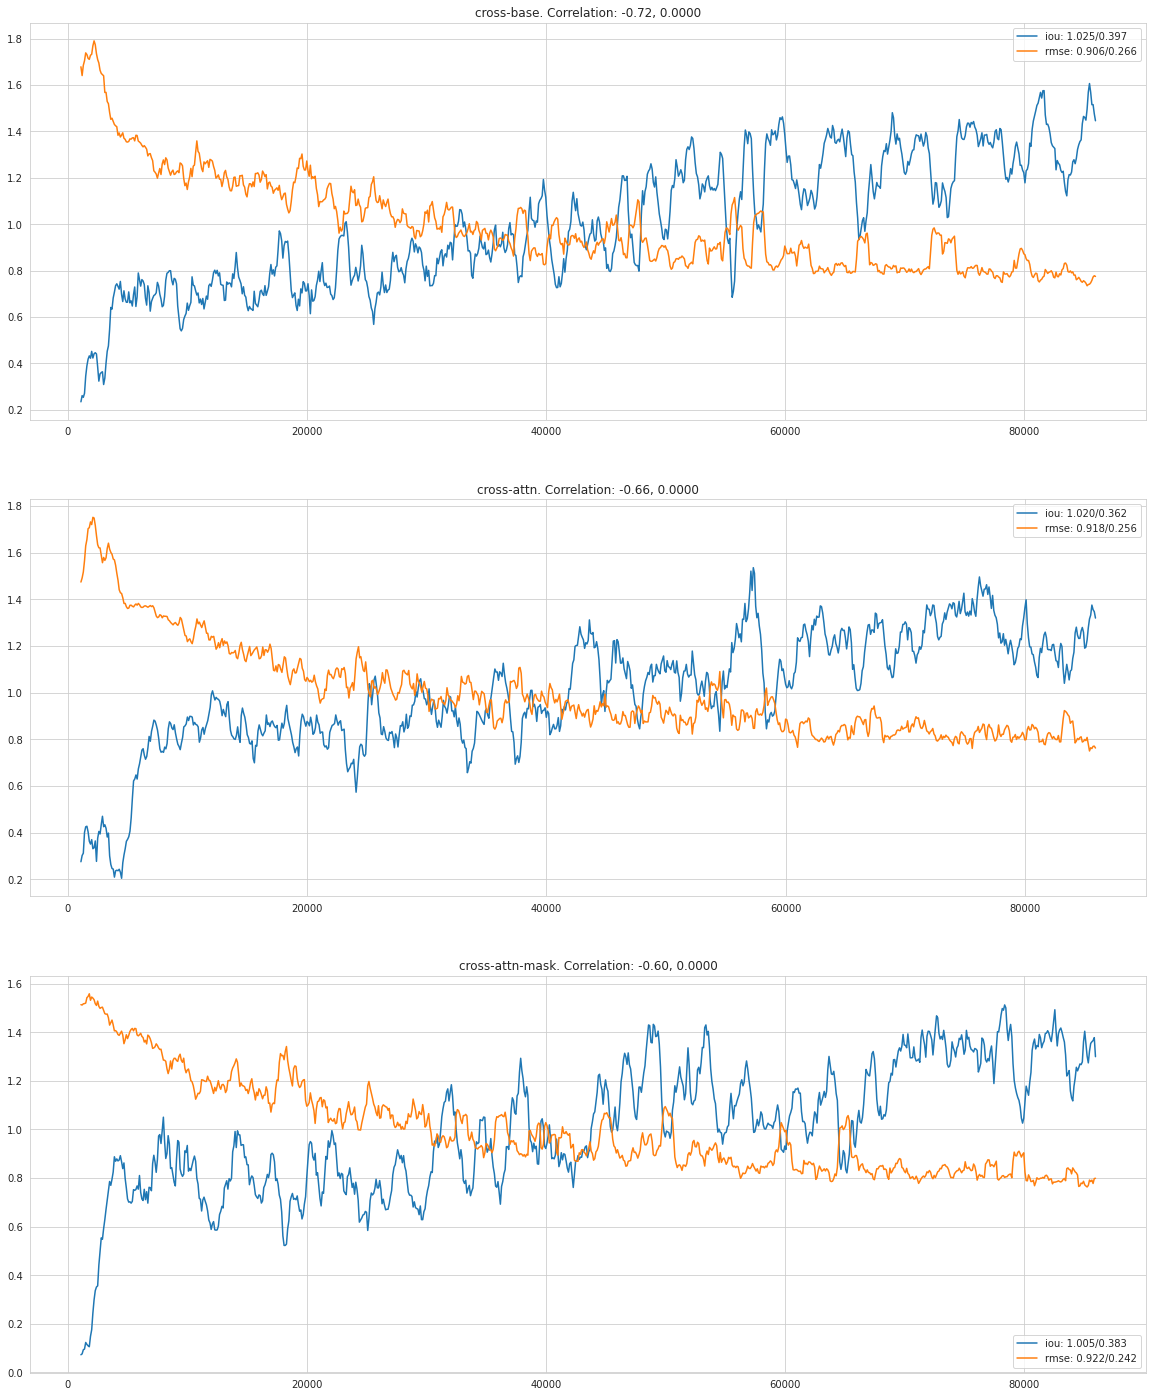

In [16]:
start_index = 1
plt.subplots(figsize=(20,10))
data = ((10,'cross-base', scale(df_spec_iou_010.iloc[start_index:min_len]), scale(df_spec_score_region_010.iloc[start_index:min_len])),
        (10, 'cross-attn',  scale(df_spec_iou_011.iloc[start_index:min_len]), scale(df_spec_score_region_011.iloc[start_index:min_len])),
        (10, 'cross-attn-mask',  scale(df_spec_iou_012.iloc[start_index:min_len]), scale(df_spec_score_region_012.iloc[start_index:min_len])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"{label}. Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"iou: {iou.median()[0]:.3f}/{iou.std()[0]:.3f}")
  plt.plot(rmse.rolling(rm).mean(), label=f"rmse: {rmse.median()[0]:.3f}/{rmse.std()[0]:.3f}")
  plt.legend();

plt.subplots_adjust(top=2);

- We have a significant negative correlation for all hypothesis.
- Models with higher weights(500,1000) have smaller gap with training progress
- 100 seems to be more consistent and less volatile, given strong negative correlation

### Correlation of Global RMSE with IOU

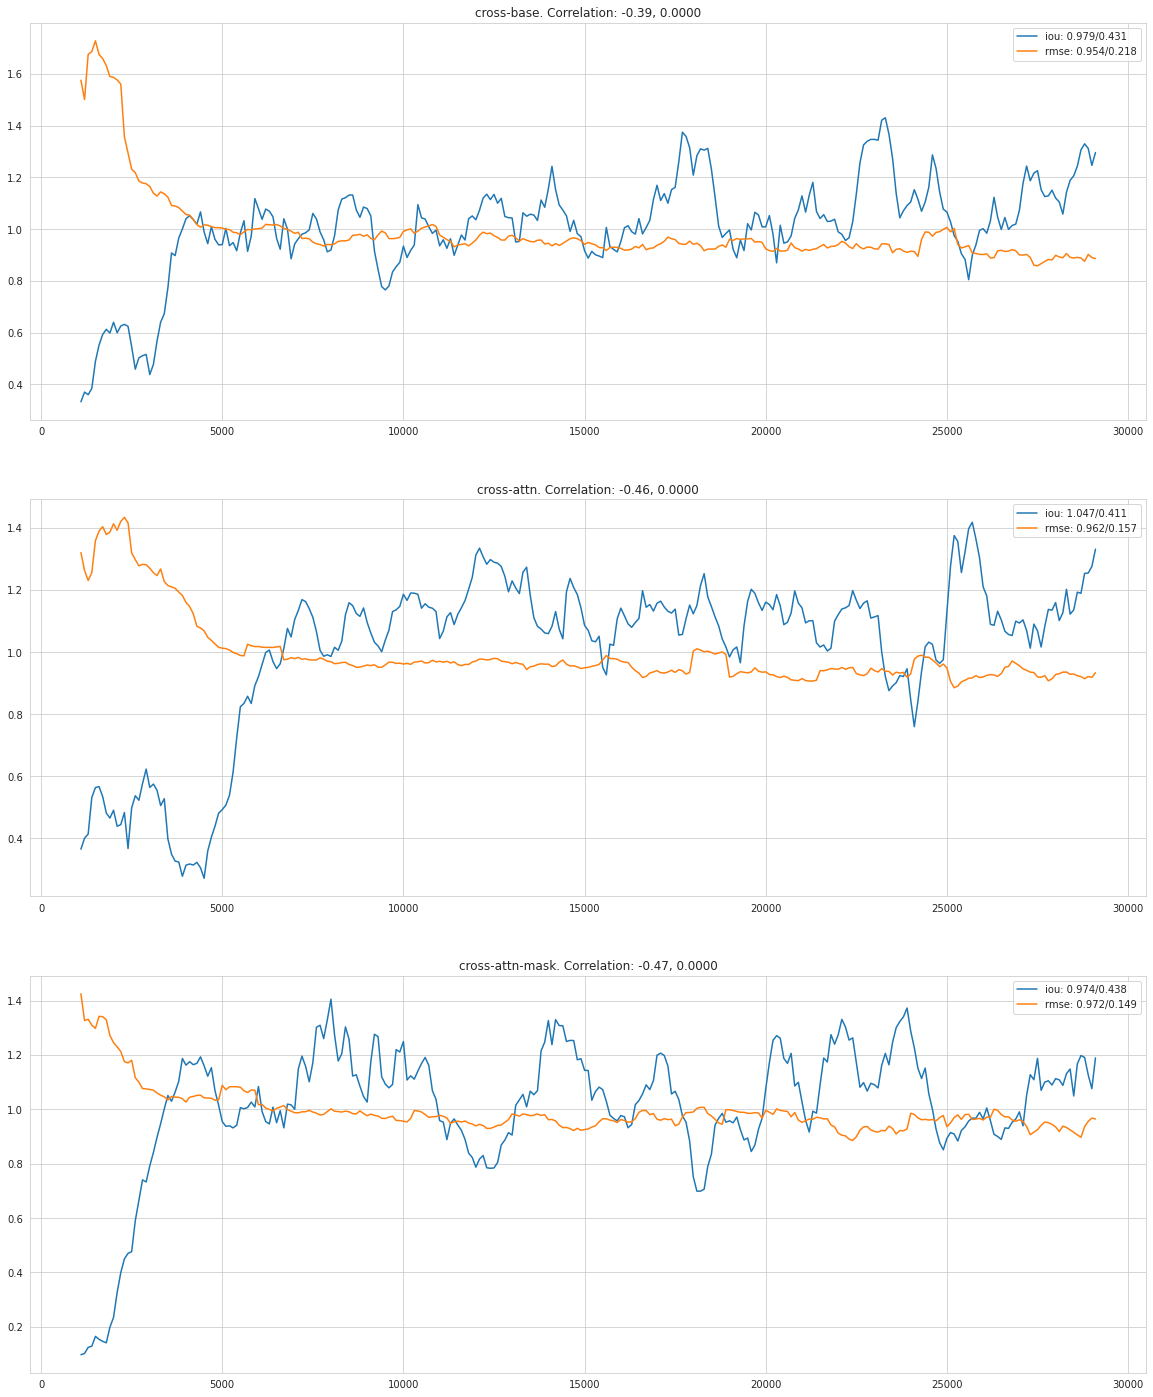

In [0]:
start_index = 1
plt.subplots(figsize=(20,10))
data = ((10,'cross-base', scale(df_spec_iou_010.iloc[start_index:min_len]), scale(df_spec_score_whole_010.iloc[start_index:min_len])),
        (10, 'cross-attn',  scale(df_spec_iou_011.iloc[start_index:min_len]), scale(df_spec_score_whole_011.iloc[start_index:min_len])),
        (10, 'cross-attn-mask',  scale(df_spec_iou_012.iloc[start_index:min_len]), scale(df_spec_score_whole_012.iloc[start_index:min_len])))

for i,(rm, label, iou, rmse) in enumerate(data):
  plt.subplot(len(data), 1, i+1)
  corr,pv = st.pearsonr(iou.values.squeeze(), rmse.values.squeeze())
  plt.title(f"{label}. Correlation: {corr:.2f}, {pv:.4f}")
  plt.plot(iou.rolling(rm).mean(), label=f"iou: {iou.median()[0]:.3f}/{iou.std()[0]:.3f}")
  plt.plot(rmse.rolling(rm).mean(), label=f"rmse: {rmse.median()[0]:.3f}/{rmse.std()[0]:.3f}")
  plt.legend();

plt.subplots_adjust(top=2);

### Look at losses

#### Adv. domain B

In [0]:
tag_gab = 'G/GAN_A2B'
df_spec_gab_010 = results_010[tag_gab]
df_spec_gab_011 = results_011[tag_gab]
df_spec_gab_012 = results_012[tag_gab]

tag_db_real = 'D/D_B_real'
df_spec_db_real_010 = results_010[tag_db_real]
df_spec_db_real_011 = results_011[tag_db_real]
df_spec_db_real_012 = results_012[tag_db_real]


tag_db_fake = 'D/D_B_fake'
df_spec_db_fake_010 = results_010[tag_db_fake]
df_spec_db_fake_011 = results_011[tag_db_fake]
df_spec_db_fake_012 = results_012[tag_db_fake]

In [18]:
df_spec_db_fake_010.shape

(8614, 1)

In [0]:
min_len = min(len(df_spec_db_fake_010), len(df_spec_db_fake_011), len(df_spec_db_fake_012))

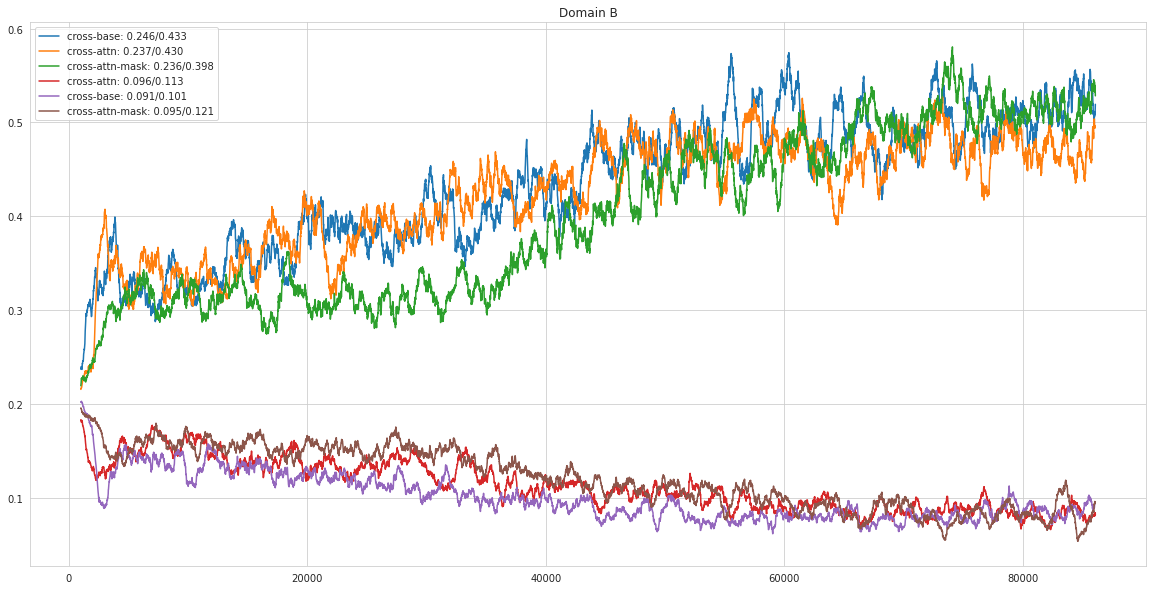

In [20]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain B")

plt.plot(df_spec_gab_010.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-base: {df_spec_gab_010.iloc[:min_len].std()[0]:.3f}/{df_spec_gab_010.iloc[:min_len].mean()[0]:.3f}');

plt.plot(df_spec_gab_011.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn: {df_spec_gab_011.std()[0]:.3f}/{df_spec_gab_011.mean()[0]:.3f}');

plt.plot(df_spec_gab_012.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn-mask: {df_spec_gab_012.iloc[:min_len].std()[0]:.3f}/{df_spec_gab_012.iloc[:min_len].mean()[0]:.3f}');

df_spec_db_fake_comb_010 = (df_spec_db_real_010 + df_spec_db_fake_010) / 2
df_spec_db_fake_comb_011 = (df_spec_db_real_011 + df_spec_db_fake_011) / 2
df_spec_db_fake_comb_012 = (df_spec_db_real_012 + df_spec_db_fake_012) / 2


plt.plot(df_spec_db_fake_comb_010.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn: {df_spec_db_fake_comb_010.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_010.iloc[:min_len].mean()[0]:.3f}');

plt.plot(df_spec_db_fake_comb_011.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-base: {df_spec_db_fake_comb_011.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_011.iloc[:min_len].mean()[0]:.3f}');

plt.plot(df_spec_db_fake_comb_012.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn-mask: {df_spec_db_fake_comb_012.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_012.iloc[:min_len].mean()[0]:.3f}');

plt.legend();

- Losses are again hard to distinguish and make the conclusions as it was on the previous stage

#### Adv. domain A

In [0]:
tag_gba = 'G/GAN_B2A'
df_spec_gba_010 = results_010[tag_gba]
df_spec_gba_011 = results_011[tag_gba]
df_spec_gba_012 = results_012[tag_gba]


tag_da_real = 'D/D_A_real'
df_spec_da_real_010 = results_010[tag_db_real]
df_spec_da_real_011 = results_011[tag_db_real]
df_spec_da_real_012 = results_012[tag_db_real]



tag_da_fake = 'D/D_A_fake'
df_spec_da_fake_010 = results_010[tag_db_fake]
df_spec_da_fake_011 = results_011[tag_db_fake]
df_spec_da_fake_012 = results_012[tag_db_fake]

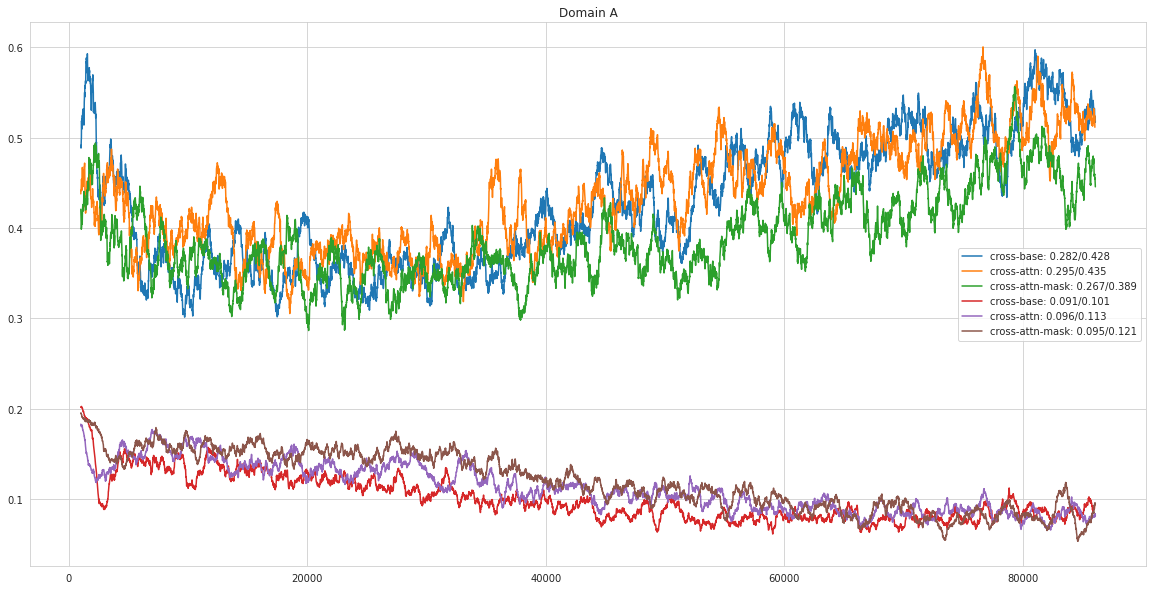

In [22]:
rm = 100
plt.subplots(figsize=(20,10))
plt.title("Domain A")

plt.plot(df_spec_gba_010.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-base: {df_spec_gba_010.iloc[:min_len].std()[0]:.3f}/{df_spec_gba_010.iloc[:min_len].mean()[0]:.3f}');
plt.plot(df_spec_gba_011.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn: {df_spec_gba_011.iloc[:min_len].std()[0]:.3f}/{df_spec_gba_011.iloc[:min_len].mean()[0]:.3f}');
plt.plot(df_spec_gba_012.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn-mask: {df_spec_gba_012.iloc[:min_len].std()[0]:.3f}/{df_spec_gba_012.iloc[:min_len].mean()[0]:.3f}');

df_spec_da_fake_comb_010 = (df_spec_da_real_010 + df_spec_da_fake_010) / 2
df_spec_da_fake_comb_011 = (df_spec_da_real_011 + df_spec_da_fake_011) / 2
df_spec_da_fake_comb_012 = (df_spec_da_real_012 + df_spec_da_fake_012) / 2

plt.plot(df_spec_db_fake_comb_011.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-base: {df_spec_db_fake_comb_011.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_011.iloc[:min_len].mean()[0]:.3f}');
plt.plot(df_spec_db_fake_comb_010.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn: {df_spec_db_fake_comb_010.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_010.iloc[:min_len].mean()[0]:.3f}');
plt.plot(df_spec_db_fake_comb_012.iloc[:min_len].rolling(rm).mean(), 
         label=f'cross-attn-mask: {df_spec_db_fake_comb_012.iloc[:min_len].std()[0]:.3f}/{df_spec_db_fake_comb_012.iloc[:min_len].mean()[0]:.3f}');

plt.legend();

#### CAM. domain B

In [0]:
tag_camB = 'G/cam_A2B'
df_spec_camB_010 = results_010[tag_camB]
df_spec_camB_011 = results_011[tag_camB]
df_spec_camB_013 = results_013[tag_camB]

tag_camA = 'G/cam_B2A'
df_spec_camA_010 = results_010[tag_camA]
df_spec_camA_011 = results_011[tag_camA]
df_spec_camA_013 = results_013[tag_camA]

NameError: ignored

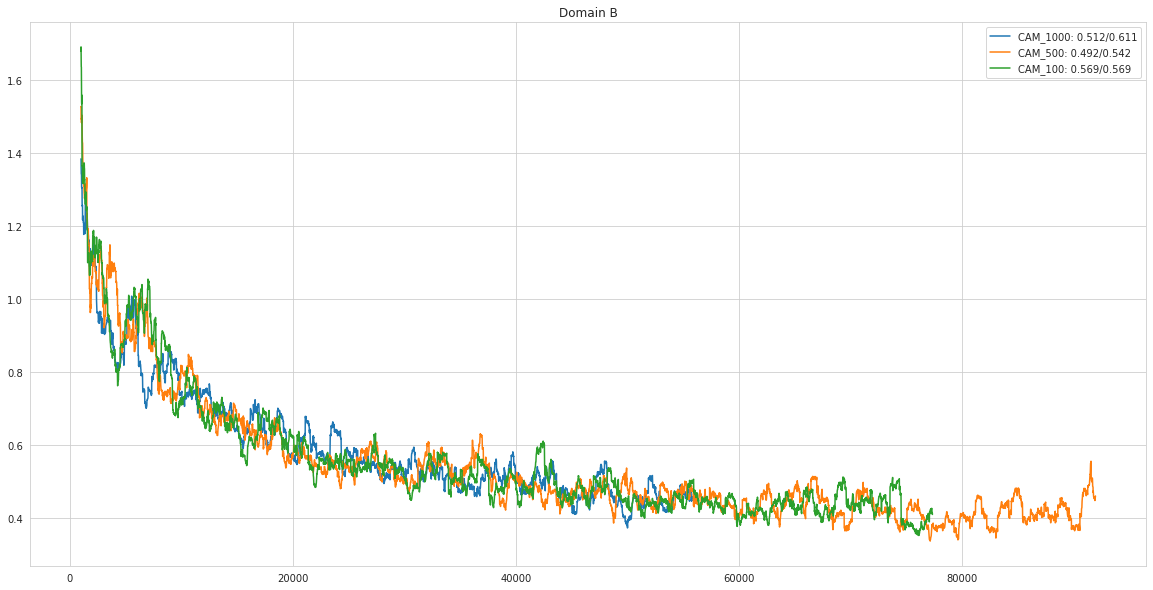

In [0]:
plt.subplots(figsize=(20,10))
rm=100
plt.title("Domain B")
plt.plot(df_spec_camB_010.rolling(rm).mean(), 
         label=f'CAM_1000: {df_spec_camB_010.std()[0]:.3f}/{df_spec_camB_010.mean()[0]:.3f}');
plt.plot(df_spec_camB_011.rolling(rm).mean(), 
         label=f'CAM_500: {df_spec_camB_011.std()[0]:.3f}/{df_spec_camB_011.mean()[0]:.3f}');
plt.plot(df_spec_camB_013.rolling(rm).mean(), 
         label=f'CAM_100: {df_spec_camB_013.std()[0]:.3f}/{df_spec_camB_013.mean()[0]:.3f}');
plt.legend();

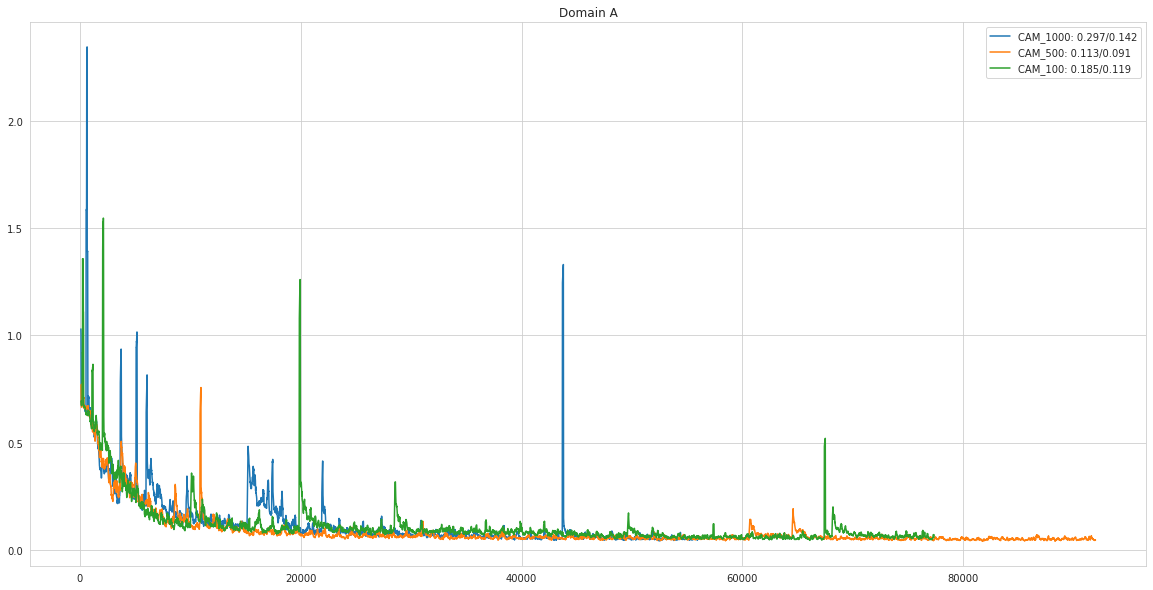

In [0]:
plt.subplots(figsize=(20,10))
rm=10
plt.title("Domain A")
plt.plot(df_spec_camA_010.rolling(rm).mean(), 
         label=f'CAM_1000: {df_spec_camA_010.std()[0]:.3f}/{df_spec_camA_010.mean()[0]:.3f}');
plt.plot(df_spec_camA_011.rolling(rm).mean(), 
         label=f'CAM_500: {df_spec_camA_011.std()[0]:.3f}/{df_spec_camA_011.mean()[0]:.3f}');
plt.plot(df_spec_camA_013.rolling(rm).mean(), 
         label=f'CAM_100: {df_spec_camA_013.std()[0]:.3f}/{df_spec_camA_013.mean()[0]:.3f}');
plt.legend();

In [0]:
tag_idtA = 'G/idt_A'
df_spec_idtA_010 = results_010[tag_idtA]
df_spec_idtA_011 = results_011[tag_idtA]
df_spec_idtA_013 = results_013[tag_idtA]

tag_idtB = 'G/idt_B'
df_spec_idtB_010 = results_010[tag_idtB]
df_spec_idtB_011 = results_011[tag_idtB]
df_spec_idtB_013 = results_013[tag_idtB]

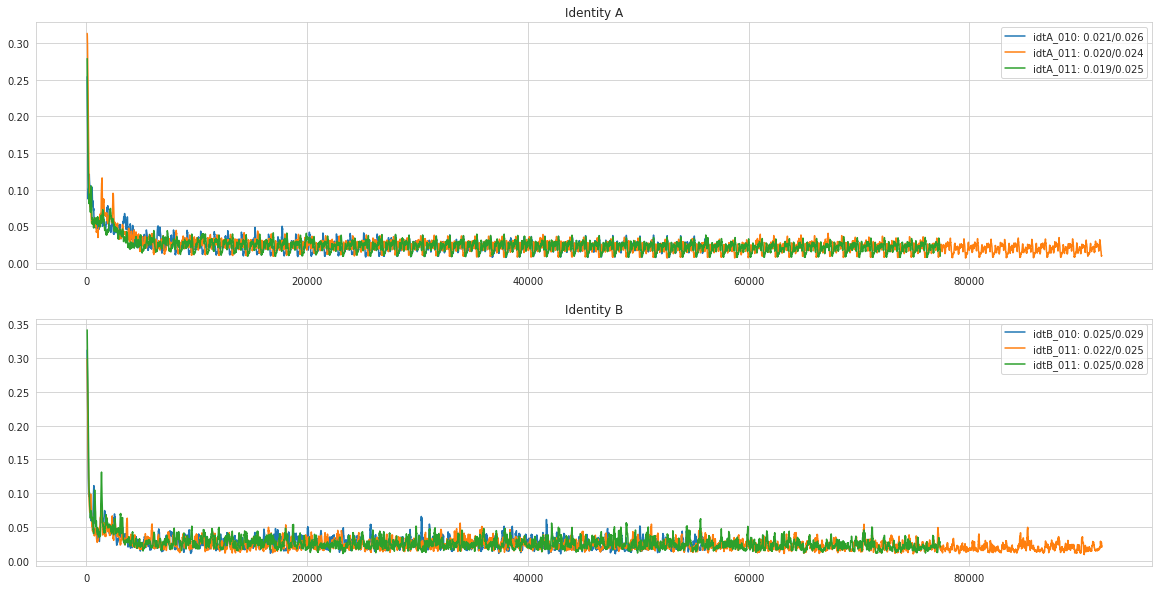

In [0]:
plt.subplots(figsize=(20,10))
rm=10

plt.subplot(2,1,1)
plt.title("Identity A")
plt.plot(df_spec_idtA_010.rolling(rm).mean(), 
         label=f'idtA_010: {df_spec_idtA_010.std()[0]:.3f}/{df_spec_idtA_010.mean()[0]:.3f}');
plt.plot(df_spec_idtA_011.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_011.std()[0]:.3f}/{df_spec_idtA_011.mean()[0]:.3f}');
plt.plot(df_spec_idtA_013.rolling(rm).mean(), 
         label=f'idtA_011: {df_spec_idtA_013.std()[0]:.3f}/{df_spec_idtA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Identity B")
plt.plot(df_spec_idtB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_idtB_010.std()[0]:.3f}/{df_spec_idtB_010.mean()[0]:.3f}');
plt.plot(df_spec_idtB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_011.std()[0]:.3f}/{df_spec_idtB_011.mean()[0]:.3f}');
plt.plot(df_spec_idtB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_idtB_013.std()[0]:.3f}/{df_spec_idtB_013.mean()[0]:.3f}');

plt.legend();

In [0]:
tag_ABA = 'G/cycle_ABA'
df_spec_ABA_010 = results_010[tag_ABA]
df_spec_ABA_011 = results_011[tag_ABA]
df_spec_ABA_013 = results_013[tag_ABA]

tag_BAB = 'G/cycle_BAB'
df_spec_BAB_010 = results_010[tag_BAB]
df_spec_BAB_011 = results_011[tag_BAB]
df_spec_BAB_013 = results_013[tag_BAB]

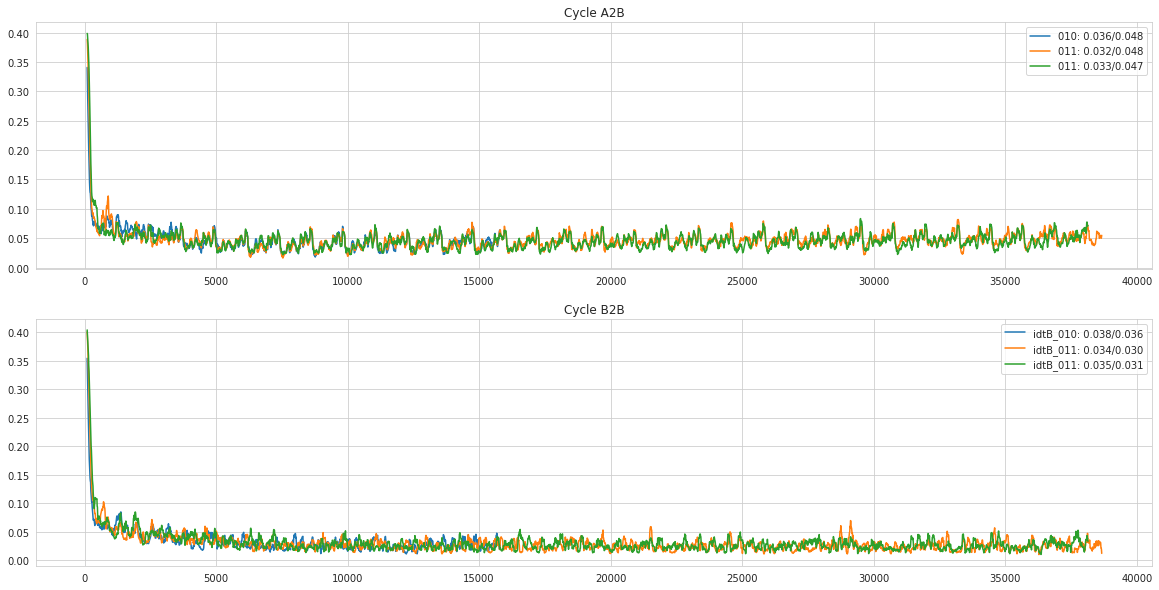

In [0]:
plt.subplots(figsize=(20,10))

plt.subplot(2,1,1)
plt.title("Cycle A2B")
plt.plot(df_spec_ABA_010.rolling(rm).mean(), 
         label=f'010: {df_spec_ABA_010.std()[0]:.3f}/{df_spec_ABA_010.mean()[0]:.3f}');
plt.plot(df_spec_ABA_011.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_011.std()[0]:.3f}/{df_spec_ABA_011.mean()[0]:.3f}');
plt.plot(df_spec_ABA_013.rolling(rm).mean(), 
         label=f'011: {df_spec_ABA_013.std()[0]:.3f}/{df_spec_ABA_013.mean()[0]:.3f}');
plt.legend();

plt.subplot(2,1,2)
plt.title("Cycle B2B")
plt.plot(df_spec_BAB_010.rolling(rm).mean(), 
         label=f'idtB_010: {df_spec_BAB_010.std()[0]:.3f}/{df_spec_BAB_010.mean()[0]:.3f}');
plt.plot(df_spec_BAB_011.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_011.std()[0]:.3f}/{df_spec_BAB_011.mean()[0]:.3f}');
plt.plot(df_spec_BAB_013.rolling(rm).mean(), 
         label=f'idtB_011: {df_spec_BAB_013.std()[0]:.3f}/{df_spec_BAB_013.mean()[0]:.3f}');

plt.legend();

### Ttest

In [0]:
import scipy.stats as st

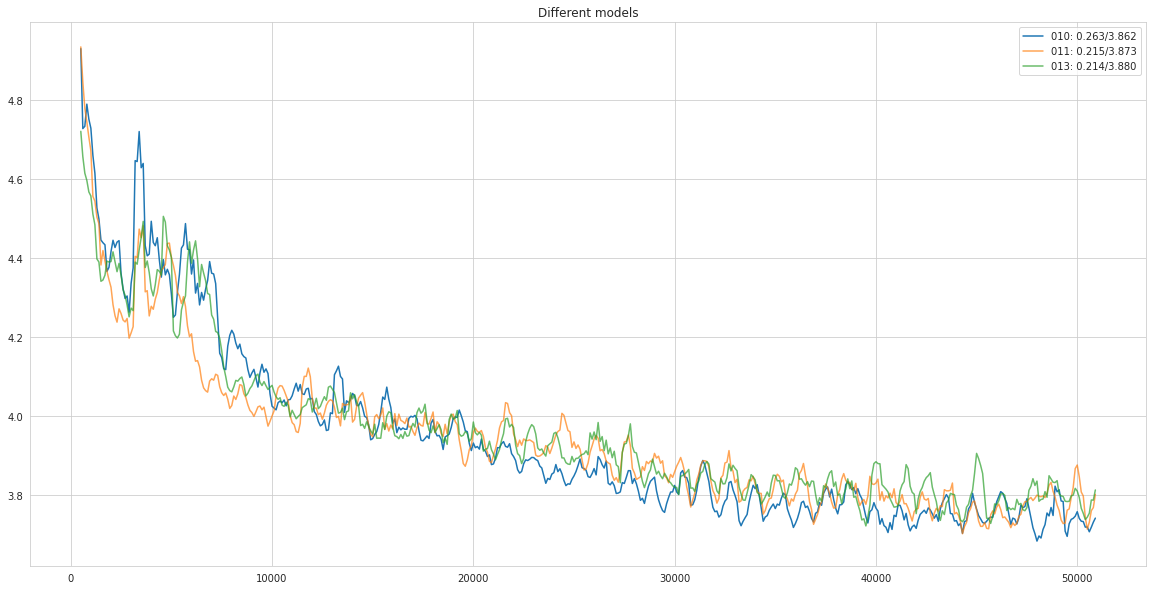

In [0]:
rm=5
plt.subplots(figsize=(20,10))
plt.title("Different models")
plt.plot(df_spec_score_010.rolling(rm).mean(), 
         label=f'010: {df_spec_score_010.std()[0]:.3f}/{df_spec_score_010.median()[0]:.3f}');
plt.plot(df_spec_score_011.rolling(rm).mean().iloc[:min_len], 
         label=f'011: {df_spec_score_011.std()[0]:.3f}/{df_spec_score_011.median()[0]:.3f}',
         alpha=0.7);
plt.plot(df_spec_score_013.rolling(rm).mean().iloc[:min_len], 
         label=f'013: {df_spec_score_013.std()[0]:.3f}/{df_spec_score_013.median()[0]:.3f}',
         alpha=0.7);
plt.legend();

In [0]:
t_1_2 = st.ttest_ind(df_spec_score_010.values, df_spec_score_011.values)
t_1_3 = st.ttest_ind(df_spec_score_010.values, df_spec_score_013.values)
t_2_3 = st.ttest_ind(df_spec_score_011.values, df_spec_score_013.values)

In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([1.71926998]), pvalue=array([0.08584809]))
 H0 vs H2: Ttest_indResult(statistic=array([0.71586739]), pvalue=array([0.47422741]))
 H1 vs H2: Ttest_indResult(statistic=array([-1.14987522]), pvalue=array([0.25043187]))


In [0]:
# take values where scores are more stable
idx = 10000
t_1_2 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_011[df_spec_score_011.index > idx].values)
t_1_3 = st.ttest_ind(df_spec_score_010[df_spec_score_010.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)
t_2_3 = st.ttest_ind(df_spec_score_011[df_spec_score_011.index > idx].values, 
                     df_spec_score_013[df_spec_score_013.index > idx].values)

In [0]:
print("H0 mean: {:.4f}, H0 std: {:.4f}".format(df_spec_score_010[df_spec_score_010.index > idx].mean().iloc[0], 
                                       df_spec_score_010[df_spec_score_010.index > idx].std().iloc[0]))
print()
print("H1 mean: {:.4f}, H1 std: {:.4f}".format(df_spec_score_011[df_spec_score_011.index > idx].mean().iloc[0], 
                                       df_spec_score_011[df_spec_score_011.index > idx].std().iloc[0]))
print()
print("H2 mean: {:.4f}, H2 std: {:.4f}".format(df_spec_score_013[df_spec_score_013.index > idx].mean().iloc[0], 
                                       df_spec_score_013[df_spec_score_013.index > idx].std().iloc[0]))

H0 mean: 3.8456, H0 std: 0.1197

H1 mean: 3.8535, H1 std: 0.1166

H2 mean: 3.8604, H2 std: 0.1120


In [0]:
print(f'H0 vs H1: {t_1_2}\n',
      f'H0 vs H2: {t_1_3}\n',
      f"H1 vs H2: {t_2_3}")

H0 vs H1: Ttest_indResult(statistic=array([-0.98959662]), pvalue=array([0.32263908]))
 H0 vs H2: Ttest_indResult(statistic=array([-1.88904765]), pvalue=array([0.05921254]))
 H1 vs H2: Ttest_indResult(statistic=array([-0.93429577]), pvalue=array([0.35038579]))
